In [70]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

def nice_df(df, axis=None, reverse=False, **kwargs):
    cm = sns.light_palette("green", as_cmap=True, reverse=reverse)
    return df.style.background_gradient(cmap=cm, axis=axis, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
%load_ext autoreload
%autoreload 2

from GolfEnv import GolfEnv8d1p
from utils import QNetwork, QNetworkSequential, MinimumExponentialLR, EpsilonGreedy, train_naive_agent, get_episode_len

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


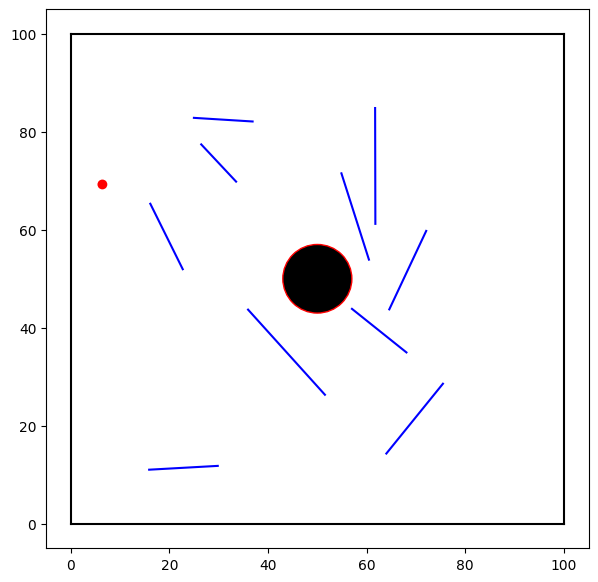

In [50]:
from GolfField import Ball, Point

reward_worse_better = lambda old_dist, new_dist: ((new_dist < old_dist) * 2 - 1) * 100

env = GolfEnv8d1p(0, 10, reward_worse_better)
env.field.hole = Ball(Point(50, 50), 7)

env.render()

In [75]:
def get_score(model, num_train_episodes=1000, num_test_episodes=500, name='model'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.004, amsgrad=True)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()
    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=model)

    episode_reward_list = train_naive_agent(env,
                                            model,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=num_train_episodes,
                                            gamma=0.9)
    
    lens = np.array([get_episode_len(env, model, epsilon_greedy) for i in tqdm(range(num_test_episodes))])
    mean_len = np.mean(lens)
    suc_rate = np.mean(lens < 99)
    print(f'{name} suc rate: {suc_rate:.3f} | mean len: {mean_len:.3f}')

    return suc_rate, mean_len


In [86]:
layers_list = [
    [16],
    [32],
    # [64],
    # [128],
    # [16, 16],
    # [32, 32],
    # [64, 64],
    # [128, 128],
    # [16, 16, 16],
    # [32, 32, 32],
    # [64, 64, 64],
    # [128, 128, 128],
]

naive_trains_result_df = pd.DataFrame(
    np.zeros((len(layers_list), 2)),
    index = [str(layers) for layers in layers_list],
    columns=["suc_rate", "mean_len"], 
)

for layers in tqdm(layers_list):
    q_network = QNetworkSequential(2, 8, layers=layers).to(device)
    suc_rate, mean_len = get_score(q_network, num_train_episodes=20, num_test_episodes=5, name=str(layers))
    naive_trains_result_df.loc[str(layers), ["suc_rate", "mean_len"]] = [suc_rate, 0]
    


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:02<00:02,  2.03s/it]

[16] suc rate: 0.200 | mean len: 84.000


100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

[32] suc rate: 0.800 | mean len: 33.600


In [101]:
def nice_df_loc(df, axis=None, reverse=False, **kwargs):
    cm = sns.light_palette("green", as_cmap=True, reverse=reverse)

    # return df.iloc[:, [0]].style.background_gradient(cmap=cm, axis=axis, **kwargs)

    # styled_df = df.style.applymap(cm, subset=['A', 'B']).applymap(color_positive_green, subset=['C'])


    def color_positive_green(val):
        color = 'green' if val > 0 else 'white'
        return f'background-color: {color}'
    
    def gradient_color(val):
        # color = 'background-color: ' + sns.light_palette("green", as_cmap=True)(val)
        color = sns.light_palette("green", as_cmap=True)(val)
        return 'background-color: %s' % color
    
    styled_df = df.style.map(gradient_color, subset=['suc_rate'])
    return styled_df



In [102]:
nice_df_loc(naive_trains_result_df, axis=0, reverse=False)


TypeError: can only concatenate str (not "tuple") to str

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:09<00:00, 10.60it/s]


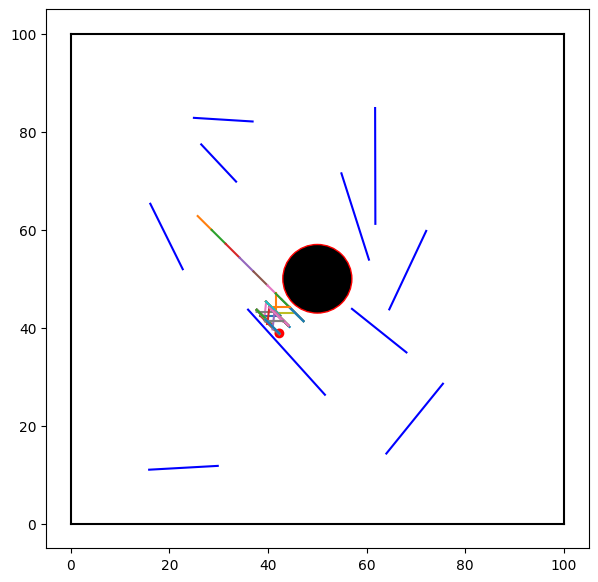

In [55]:
NUMBER_OF_TRAININGS = 50
naive_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(2, 8, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    # Train the q-network

    episode_reward_list = train_naive_agent(env,
                                            q_network,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=100,
                                            gamma=0.9)
    naive_trains_result_list[0].extend(range(len(episode_reward_list)))
    naive_trains_result_list[1].extend(episode_reward_list)
    naive_trains_result_list[2].extend([train_index for _ in episode_reward_list])

naive_trains_result_df = pd.DataFrame(np.array(naive_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
naive_trains_result_df["agent"] = "Naive"

# Save the action-value estimation function of the last train

torch.save(q_network, "naive_q_network.pth")

env.close()

env.render()

In [56]:
lens = np.array([get_episode_len(env, q_network, epsilon_greedy) for i in tqdm(range(500))])
print('Mean route len:', np.mean(lens))
print('Success rate:', np.mean(lens < 99))

100%|██████████| 500/500 [00:32<00:00, 15.47it/s]

Mean route len: 79.724
Success rate: 0.246


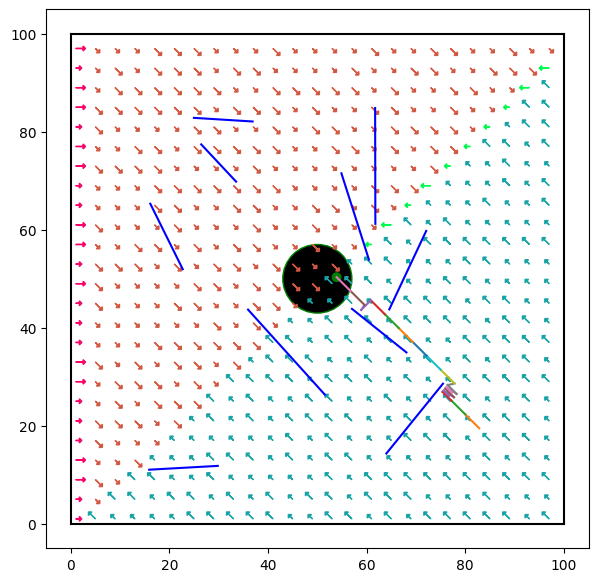

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 7))


func_for_action = lambda x, y: (20 + np.random.rand() * 130, 0.5)
func_for_action = lambda x, y: (q_network(torch.tensor([x, y], dtype=torch.float32)).squeeze().argmax().item() * (360 / 8), 1)

func_for_action(40, 30)
env.render_wind(func_for_action, ax)

